In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Model

In [320]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from weather import Weather
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

weather = Weather().get_data()
weather = Weather().clean_data(weather)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_term','summit_date1', 'summit_bid',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')
exped['rope'] = np.where(exped['rope']>0, True, False)

exped = exped.set_index('summit_date')
weather = weather.set_index('date_time')

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])

weather['pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['pressure_futur'] - weather['pressure_past']

# Merge DataFrames
df = exped.merge(weather, how='left', left_index=True, right_index=True)
df = df.reset_index()
df = df.rename(columns={'index' : 'summit_date'})
df = df.merge(member, on='exp_id', how = 'right')
df = df.dropna(subset=['summit_date', 'bc_date'])

# Feature Engineering (2/2)
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = weather.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow
    
feature_to_drop = ['primrte', 'disabled','moonrise', 'moonset', 
                   'sunrise', 'sunset', 'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason',
                   'pressure_past', 'pressure_futur', 'uvIndex', 'o2_used', 'date_season']

df.drop(columns= feature_to_drop, inplace=True)

In [278]:
df.columns

Index(['peak_id', 'host', 'summit_days', 'tot_days', 'camps', 'rope',
       'tot_members', 'tot_hired', 'no_hired', 'comrte', 'stdrte',
       'peak_height', 'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'summit_success', 'age', 'cumul_snow', 'ratio_days'],
      dtype='object')

In [343]:
df['ratio_days'] = df['summit_days']/(df['tot_days']+1) + np.log(df['tot_days']+1)

In [344]:
df['ratio_camps'] = df['camps']/(df['tot_days']+1) + np.log(df['camps']+1)


In [376]:
from scipy import stats
df['box_camps']=stats.boxcox(abs((df['camps']+1)))[0]

In [378]:
from sklearn.preprocessing import PolynomialFeatures
interactions = PolynomialFeatures(interaction_only=True)
df[['poly1', 'poly2', 'poly3', 'poly4']] =interactions.fit_transform(df[['camps', 'tot_days']])

df['ultime_ratio'] = df['ratio_days'] * (df['ratio_camps']-df['ratio_camps'].mean())**2 * df['peak_height']**0.5 

In [296]:
df.drop(index = df[(df['tot_days']==0) & (df['summit_days']==0)].index, inplace=True)

In [335]:
df.drop(['ultime_ratio'], axis=1, inplace=True)

In [404]:
df.drop(index = df[df['status']=='bc member'].index, inplace = True)

In [406]:
from sklearn.base import BaseEstimator, TransformerMixin

class BoolImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3)

In [242]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [298]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier(n_estimators = 400,
                            max_depth = 18,
                            learning_rate = 0.115,
                            gamma = 0.8,
                            min_child_weight = 4,
                            colsample_bytree = 0.3
                            )
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.82      0.78      0.80      3197
        True       0.80      0.83      0.82      3350

    accuracy                           0.81      6547
   macro avg       0.81      0.81      0.81      6547
weighted avg       0.81      0.81      0.81      6547



In [383]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier(n_estimators = 200,
                            max_depth = 14,
                            learning_rate = 0.01,
                            gamma = 0.8,
                            min_child_weight = 1,
                            colsample_bytree = 0.3
                            )
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.86      0.76      0.81      3252
        True       0.79      0.88      0.83      3295

    accuracy                           0.82      6547
   macro avg       0.83      0.82      0.82      6547
weighted avg       0.83      0.82      0.82      6547



In [403]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.78      0.81      3252
        True       0.80      0.87      0.83      3295

    accuracy                           0.82      6547
   macro avg       0.82      0.82      0.82      6547
weighted avg       0.82      0.82      0.82      6547



In [407]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.82      0.79      0.80      3131
        True       0.81      0.84      0.83      3398

    accuracy                           0.82      6529
   macro avg       0.82      0.81      0.82      6529
weighted avg       0.82      0.82      0.82      6529



## Test with new data

In [6]:
test = X.reset_index()
test = test.iloc[[1122]]
test1 = X.reset_index()
test1 = test1.iloc[[1122]]

In [7]:
test['rope'] = True
test['camps'] = 5
test['summit_days'] = 20

test1['rope'] = False
test1['camps'] = 2
test1['summit_days'] = 10

In [8]:
X_trans = clf.transform(test)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.02564985, 0.97435015]], dtype=float32)

In [9]:
X_trans = clf.transform(test1)
X_tr = X_trans.toarray()
boost.predict_proba(X_tr)

c:\users\kyril\.venvs\himalaya\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.42166865, 0.57833135]], dtype=float32)

## Features

### Feature Importance

In [177]:
# feature importance
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
dfeat = dfeat[dfeat['feature'].str.contains('peak_id')]
dfeat = dfeat.sort_values(by='value')

val = 0
# plot
plt.bar(dfeat.loc[dfeat['value']> val , 'feature'], dfeat.loc[dfeat['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

ValueError: Length of values (227) does not match length of index (248)

In [179]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

palette = sns.color_palette("Blues_r", n_colors=10)
palette.reverse()

plt.figure(figsize=(15,7))
sns.barplot(x=df_feat_2.tail(10)['feature'], y=df_feat_2.tail(10)['value'], palette=palette)
plt.xticks(rotation=90)
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True, left=True)
plt.yticks([])
plt.ylabel('')
plt.title('Features Importance Without O2 Used', fontdict = font)
plt.show()

ValueError: Length of values (227) does not match length of index (248)

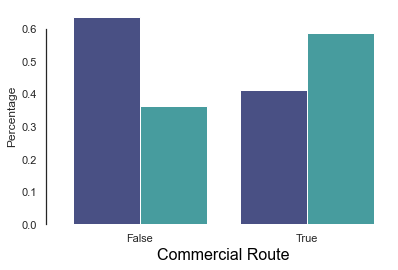

In [253]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16}

x, y, hue = "comrte", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="mako")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Commercial Route', fontdict=font)
plt.show()

In [250]:
df.groupby('comrte').agg({'summit_success': np.sum, 'summit_success': 'count'})

,summit_success
comrte,
False,7147
True,14674


In [252]:
df.groupby('comrte').agg({'summit_success': np.sum})

,summit_success
comrte,
False,2599
True,8607


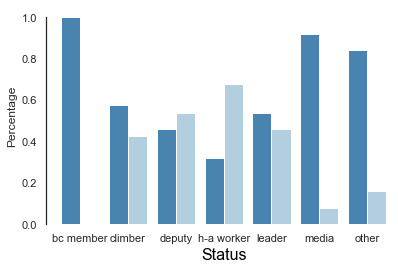

In [184]:
x, y, hue = "status", "Percentage", "summit_success"
prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

splot = sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Status', fontdict=font)
plt.show()

In [215]:
member = Members().get_data()
member = Members().clean_data(member)

In [202]:
colors = ["#db525a", "#1cb992"]

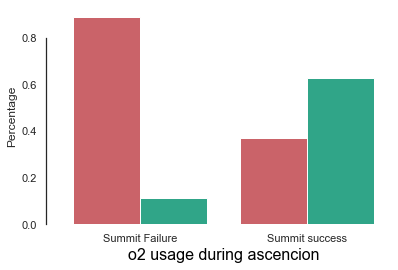

In [224]:
x, y, hue = "o2_used", "Percentage", "summit_success"
prop_df = (member[x]
           .groupby(member[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())
sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(x=hue, y=y, hue=x, data=prop_df)
sns.set()
sns.set_style('white')
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('o2 usage during ascencion', fontdict=font)
plt.show()

In [217]:
def summit_succes(x):
    if x == True:
        return "Summit success"
    elif x == False:
        return 'Summit Failure'
member["summit_success"] = member["summit_success"].map(summit_succes)

In [218]:
member[["summit_success"]].value_counts()

summit_success
Summit Failure    13340
Summit success    13165
dtype: int64

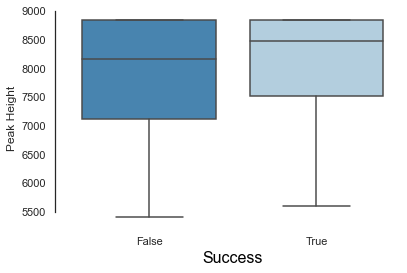

In [207]:
sns.boxplot(y=df["peak_height"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Peak Height')
plt.show()

NameError: name 'font' is not defined

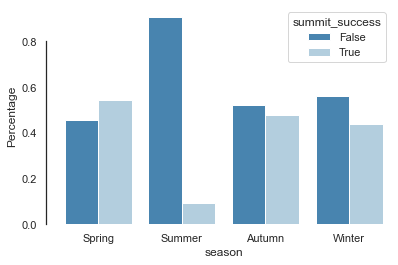

In [182]:
x, y, hue = "season", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

field = "season"
day_order = ["Spring", "Summer", "Autumn", "Winter"]
prop_df = prop_df.set_index(field).loc[day_order]

sns.barplot(x=prop_df.index, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Season', fontdict=font)
plt.legend().remove()
plt.show()

In [ ]:
sns.boxplot(y=df["summit_days"],x=df['summit_success'], palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Summit Days')
plt.show()

In [ ]:
sns.boxplot(y=df["camps"],x=df['summit_success'], palette="Blues_r")
plt.ylim((0,10))
sns.despine(offset=10, trim=True, bottom=True)
plt.xlabel('Success', fontdict=font)
plt.ylabel('Number of Camps')
plt.show()

In [ ]:
x, y, hue = "no_hired", "Percentage", "summit_success"

prop_df = (df[hue]
           .groupby(df[x])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, palette="Blues_r")
sns.despine(offset=10, trim=True, bottom=True)
plt.legend().remove()
plt.xlabel('Hired Sherpas', fontdict=font)
plt.show()

### Feature permutation

In [227]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(boost, X_test, y_test)

In [228]:
sorted_idx = perm_importance.importances_mean.argsort()

Y = list(sorted_idx)
sorted_feat = [x for _,x in sorted(zip(Y,feature_names))]

dfeat_prem = pd.DataFrame(data=perm_importance.importances_mean[sorted_idx])
dfeat_prem['feature'] = sorted_feat
dfeat_prem.columns = ['value', 'feature']
dfeat_prem = dfeat_prem.sort_values(by='value')
dfeat_prem = dfeat_prem[~dfeat_prem['feature'].str.contains('peak')]
dfeat_prem = dfeat_prem[dfeat_prem['value']!=0]


val = 0.005
# plot
plt.bar(dfeat_prem.feature, dfeat_prem.value)
plt.xticks(rotation=90)
plt.show()

ValueError: Length of values (227) does not match length of index (248)

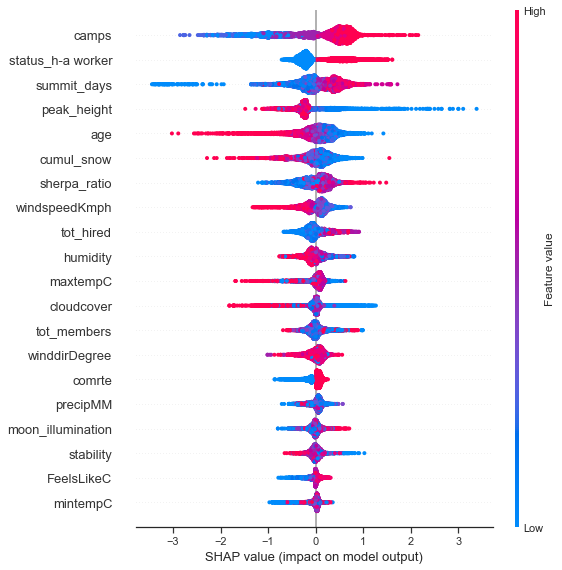

In [244]:
import shap
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names= feature_names)

In [238]:
shap_values.shape

(6547, 248)

In [243]:
len(feature_names)

248

## Other Models

In [ ]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=500)
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1


def initialize_model():
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(176,)))
    model.add(layers.Dense(200, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(100, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights=True)

model_NN = initialize_model()

history = model_NN.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= 300, 
                    batch_size=8,
                    verbose=0,
                   callbacks = [es])

y_pred_NN = model_NN.predict_classes(X_test)
print(classification_report(y_test, y_pred_NN))

## RandomSearchCV

### XGB

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {'booster' : ['gbtree', 'gblinear'],
        'min_child_weight': [0.1, 1, 5, 10, 50],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 25, 50],
        'learning_rate': [0.0001, 0.001, 0.1, 1],
        'n_estimators': [50, 100, 250, 500],
        'reg_alpha': [0.0001, 0.001, 0.1, 1],
        'reg_lambda': [0.0001, 0.001, 0.1, 1]
        }

model = XGBClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=0, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

In [ ]:
boost

In [ ]:
best_model = random_search.best_estimator_
best_model

In [ ]:
y_xgbCV = best_model.predict(X_test)
print(classification_report(y_test, y_xgbCV))

### RFC

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators' : [100,200,500],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split': [2, 3, 5],
        'max_depth': [5, 10, 25, 50],
        'min_samples_leaf': [1, 3, 5],
        'max_features': ["sqrt", "log2"]
        }

model = RandomForestClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

In [ ]:
best_RFC = random_search.best_estimator_

In [ ]:
best_RFC

In [ ]:
ypred = best_RFC.predict(X_test)
print(classification_report(y_test, ypred))

# Test xgb_model.py

In [1]:
from xgb_model import HimalXGB

model = HimalXGB().train_model()

In [4]:
to_predict = pd.DataFrame(columns=['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'age', 'cumul_snow'])
# peak_height = peak[peak['peak_id']==mountain]['height_m'].values[0]
# sherpa_ratio = total_members/total_hired
to_predict = to_predict.append({'peak_id':'EVER', 'host':'China', 'summit_days':18, 'camps':7, 'rope':bool("True"), 'tot_members':20,
       'tot_hired':7, 'no_hired':bool("False"), 'comrte': bool("True"), 'stdrte':bool("False"), 'peak_height':8000,
       'sherpa_ratio': 0.3 , 'maxtempC':-2.277021, 'mintempC': -9.736381, 'totalSnow_cm': 1.754977, 'sunHour': 10.275210,
       'moon_illumination': 48.470733, 'DewPointC' :-8.459432 , 'FeelsLikeC':-9.604752 , 'HeatIndexC': -5.661692,
       'WindGustKmph':13.669081, 'cloudcover': 45.633150, 'humidity': 81.966314, 'precipMM': 2.532628, 'pressure' : 1013.688569,
       'visibility':7.486308, 'winddirDegree':211.464793, 'windspeedKmph': 10.086931, 'stability': 0.045808, 'season' :"Spring",
       'sex_M': 1, 'status': "climber", 'age': 34, 'cumul_snow':43}, ignore_index=True)

In [5]:
y_pred = HimalXGB().predict_model(to_predict)
y_pred

array([[0.7708429 , 0.22915712, 0.        ]], dtype=float32)

# Model without weather

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_bid','summit_term','summit_date1',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])
exped['rope'] = np.where(exped['rope']>0, True, False)



# Merge DataFrames
df = exped.merge(member, on='exp_id', how = 'right')


feature_to_drop = ['primrte', 'disabled', 
                   'traverse', 'parapente', 'solo', 'ski', 'speed', 
                   'summit_date', 'exp_id', 'bc_date', 'term_reason']

df.drop(columns= feature_to_drop, inplace=True)

In [ ]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

bool_transformer = Pipeline(steps=[
    ('imputer', BoolImputer())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('bool', bool_transformer, col_bool),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [ ]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[2][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + col_bool + ohe_col

In [104]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.84      0.77      0.80      3195
        True       0.80      0.86      0.83      3352

    accuracy                           0.82      6547
   macro avg       0.82      0.82      0.82      6547
weighted avg       0.82      0.82      0.82      6547



In [ ]:
# feature without peak_id
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak_id')]
df_feat_2 = df_feat_2.sort_values(by='value')

# plot
plt.figure(figsize=(15,7))
plt.bar(df_feat_2.feature, df_feat_2.value)
plt.xticks(rotation=90)
plt.show()

# Peaks GPS

In [ ]:
import pandas as pd

#gps = pd.read_excel('data/Peaks_GPS.xls')

gps = pd.read_excel('data/main_peaks.xlsx')

In [ ]:
import re

def coord(x):
    numbers = re.findall(r'\d+', x)
    unit = int(numbers[0])
    dec = int(numbers[1])/60
    cent = int(numbers[2])/3600
    
    return round(unit+dec+cent,4)

In [ ]:
gps['lat'] = gps['lat'].apply(lambda x: coord(x))
gps['lon'] = gps['lon'].apply(lambda x: coord(x))

In [ ]:
import folium

m = folium.Map(
    location=[27.98, 86.92],
    zoom_start=8,
    tiles='Stamen Terrain'
)

feature_group = folium.FeatureGroup("Locations")
for lat, lng, name in zip(gps.lat, gps.lon, gps.peak_name):
    feature_group.add_child(folium.Marker(location=[lat,lng], popup=name))

m.add_child(feature_group)

folium.Marker(
    location=[27.948056, 86.810278],
    popup='Weather Station',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)


m

# Dash

In [5]:
df = pd.read_csv('data/matching_table.csv')

In [6]:
df['summit_date'] = pd.to_datetime(df['summit_date'])

In [259]:
peak, year, season = "Langmoche Ri", "2012", 'All'

In [7]:
years = [{'label':i, 'value' : str(i)} for i in range(df.year.min(), df.year.max()+1)]
years.append({'label' : df.year.max()+1, 'value' : 'All'})

In [8]:
years

[{'label': 2010, 'value': '2010'},
 {'label': 2011, 'value': '2011'},
 {'label': 2012, 'value': '2012'},
 {'label': 2013, 'value': '2013'},
 {'label': 2014, 'value': '2014'},
 {'label': 2015, 'value': '2015'},
 {'label': 2016, 'value': '2016'},
 {'label': 2017, 'value': '2017'},
 {'label': 2018, 'value': '2018'},
 {'label': 2019, 'value': '2019'},
 {'label': 2020, 'value': '2020'},
 {'label': 2021, 'value': 'All'}]

In [298]:
import dash_core_components as dcc

years = {i : str(i) for i in range(df.year.min(), df.year.max()+1)}
years.update({df.year.max()+1 : 'All'})

peak, year, season = 'Everest', '2010', 'Spring'

if year == 'All':
    dff = df[(df.peak_name==peak)\
                 &(df.year <= list(years.keys())[-1])\
                 &(df.season.str.contains(season))]
else:
    dff = df[(df.peak_name==peak)\
             &(df.year == int(year))\
             &(df.season.str.contains(season))]
    
dcc.Slider(
        id='input_year',
        min=df.year.min(),
        max='All',
        step=None,
        marks=years,
        value=df.year.max()
    )

Slider(id='input_year', marks={2010: '2010', 2011: '2011', 2012: '2012', 2013: '2013', 2014: '2014', 2015: '2015', 2016: '2016', 2017: 'All'}, value=2016, min=2010, max='All')

In [311]:
season_list = ['Spring', 'Summer', 'Autumn', 'Winter', 'All']
[{'label' : i, 'value' : str(i)} for i in season_list]

[{'label': 'Spring', 'value': 'Spring'},
 {'label': 'Summer', 'value': 'Summer'},
 {'label': 'Autumn', 'value': 'Autumn'},
 {'label': 'Winter', 'value': 'Winter'},
 {'label': 'All', 'value': 'All'}]

In [306]:
[
        {'label': 'New York City', 'value': 'NYC'},
        {'label': 'Montréal', 'value': 'MTL'},
        {'label': 'San Francisco', 'value': 'SF'}
    ]

[{'label': 'New York City', 'value': 'NYC'},
 {'label': 'Montréal', 'value': 'MTL'},
 {'label': 'San Francisco', 'value': 'SF'}]

# PCA & Tsne

In [ ]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_train)

In [ ]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = 2
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y_train) # Visualizing the PCA output

In [ ]:
# PCA 50

pca_50 = PCA(n_components=30)
pca_result_50 = pca_50.fit_transform(X_train)
fashion_pca_tsne = TSNE(random_state=21).fit_transform(pca_result_50)
fashion_scatter(fashion_pca_tsne, y_train)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

features = X_train

tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(features, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_train, labels={'color': 'Success'}
)
fig.update_traces(marker_size=8)
fig.show()

In [231]:
a = np.array([1,2,np.nan])

In [232]:
a

array([ 1.,  2., nan])

In [234]:
np.nanmean(a)

1.5

In [12]:
mountain= 'EVER'
host = "China"
days=23
camps=5
rope="True"
total_members = 20
total_hired =10
hired ="True"
comroute = "True"
stanroute = "True"
peak_height =8000
sex=1
status ='climber'
age=20
season = "Spring"


In [10]:
X.columns

Index(['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'age', 'cumul_snow'],
      dtype='object')

In [13]:
to_predict = pd.DataFrame(columns=['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'age', 'cumul_snow'])



sherpa_ratio = total_members/total_hired

to_predict = to_predict.append({'peak_id':mountain, 'host':host, 'summit_days':int(days), 'camps':int(camps), 'rope':bool(rope), 'tot_members':int(total_members),
       'tot_hired':int(total_hired), 'no_hired':bool(hired), 'comrte': bool(comroute), 'stdrte':bool(stanroute), 'peak_height':peak_height,
       'sherpa_ratio': sherpa_ratio , 'maxtempC':-2.277021, 'mintempC': -9.736381, 'totalSnow_cm': 1.754977, 'sunHour': 10.275210,
       'moon_illumination': 48.470733, 'DewPointC' :-8.459432 , 'FeelsLikeC':-9.604752 , 'HeatIndexC': -5.661692,
       'WindGustKmph':13.669081, 'cloudcover': 45.633150, 'humidity': 81.966314, 'precipMM': 2.532628, 'pressure' : 1013.688569,
       'visibility':7.486308, 'winddirDegree':211.464793, 'windspeedKmph': 10.086931, 'stability': 0.045808, 'season' :season,
       'sex_M': int(sex), 'status': status, 'age': int(age), 'cumul_snow':43}, ignore_index=True)

In [16]:
json_predict = to_predict.to_dict(orient="records")

In [19]:
json_predict[0].keys()


dict_keys(['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members', 'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height', 'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season', 'sex_M', 'status', 'age', 'cumul_snow'])

In [87]:
col_float= []
col_num = []
for col in df.columns:
    if df[col].dtype == "float64":
        col_float.append(col)
    if df[col].dtype == "int64":
        col_num.append(col)

In [44]:
col_float

['sherpa_ratio',
 'maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'moon_illumination',
 'DewPointC',
 'FeelsLikeC',
 'HeatIndexC',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'visibility',
 'winddirDegree',
 'windspeedKmph',
 'stability',
 'sex_M',
 'age',
 'cumul_snow']

In [45]:
format_input = {}
for col in X.columns:
    if col in col_bool:
        format_input[col] = f'bool(input["{col}"])'
    if col in col_float:
        format_input[col] = f'float(input["{col}"])'
    if col in col_num:
        format_input[col] = f'int(input["{col}"])'
    if col in col_object:
        format_input[col] = f'str(input["{col}"])'

In [46]:
format_input

{'peak_id': 'str(input["peak_id"])',
 'host': 'str(input["host"])',
 'rope': 'bool(input["rope"])',
 'no_hired': 'bool(input["no_hired"])',
 'comrte': 'bool(input["comrte"])',
 'stdrte': 'bool(input["stdrte"])',
 'sherpa_ratio': 'float(input["sherpa_ratio"])',
 'maxtempC': 'float(input["maxtempC"])',
 'mintempC': 'float(input["mintempC"])',
 'totalSnow_cm': 'float(input["totalSnow_cm"])',
 'sunHour': 'float(input["sunHour"])',
 'moon_illumination': 'float(input["moon_illumination"])',
 'DewPointC': 'float(input["DewPointC"])',
 'FeelsLikeC': 'float(input["FeelsLikeC"])',
 'HeatIndexC': 'float(input["HeatIndexC"])',
 'WindGustKmph': 'float(input["WindGustKmph"])',
 'cloudcover': 'float(input["cloudcover"])',
 'humidity': 'float(input["humidity"])',
 'precipMM': 'float(input["precipMM"])',
 'pressure': 'float(input["pressure"])',
 'visibility': 'float(input["visibility"])',
 'winddirDegree': 'float(input["winddirDegree"])',
 'windspeedKmph': 'float(input["windspeedKmph"])',
 'stability':

In [47]:
X.columns

Index(['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'age', 'cumul_snow'],
      dtype='object')

In [166]:
api_url = "https://himalapi.herokuapp.com/"
# api_url = "http://127.0.0.1:8080/"

In [170]:

pred = X.sample(n=1).to_dict(orient="records")

In [171]:
import requests
r = requests.get(api_url+"predict_success", json=pred)

In [172]:
r.json()

{'predictions': 0.869}

In [165]:
pred

[{'peak_id': 'MANA',
  'host': 'Nepal',
  'summit_days': 19,
  'camps': 4,
  'rope': False,
  'tot_members': 10,
  'tot_hired': 5,
  'no_hired': False,
  'comrte': True,
  'stdrte': True,
  'peak_height': 8163,
  'sherpa_ratio': 0.5,
  'maxtempC': -2.0,
  'mintempC': -9.0,
  'totalSnow_cm': 1.6,
  'sunHour': 10.2,
  'moon_illumination': 45.0,
  'DewPointC': -6.0,
  'FeelsLikeC': -8.0,
  'HeatIndexC': -4.0,
  'WindGustKmph': 13.0,
  'cloudcover': 39.0,
  'humidity': 88.0,
  'precipMM': 3.8,
  'pressure': 1014.0,
  'visibility': 7.0,
  'winddirDegree': 192.0,
  'windspeedKmph': 9.0,
  'stability': 0.33333333333337123,
  'season': 'Autumn',
  'sex_M': 1.0,
  'status': 'h-a worker',
  'age': 33.0,
  'cumul_snow': 19.4}]

In [111]:
import joblib

In [116]:
pred_test = X.sample(n=1)
pipeline = joblib.load('dash/assets/pipe_transformation.joblib')
model = joblib.load('dash/assets/XGB_model.joblib')

In [117]:
pred_test = pipeline.transform(pred_test)
a =model.predict_proba(pred_test)

In [124]:
round(float(a[0][1]),2)

0.05

In [119]:
a

array([[0.94866455, 0.05133543]], dtype=float32)

In [246]:
df[df['status']=='bc member']['summit_success']

1        False
1671     False
2025     False
2101     False
2109     False
2515     False
2863     False
2990     False
3281     False
3283     False
4170     False
4173     False
4178     False
4987     False
5248     False
5565     False
5616     False
5716     False
5748     False
6567     False
6887     False
6929     False
7130     False
7741     False
7742     False
7743     False
7744     False
8088     False
8094     False
8205     False
8501     False
8508     False
8623     False
9650     False
9803     False
10059    False
10160    False
10711    False
10977    False
11442    False
11677    False
11681    False
12647    False
12887    False
14555    False
15483    False
15487    False
15590    False
15759    False
18055    False
18057    False
18791    False
19617    False
20584    False
20924    False
21151    False
23567    False
24173    False
24256    False
Name: summit_success, dtype: bool

In [264]:
df[(df['summit_days']<10) & (df['summit_success']==True)]

,peak_id,host,summit_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,...,visibility,winddirDegree,windspeedKmph,stability,season,sex_M,status,summit_success,age,cumul_snow
0,TKRG,Nepal,6,0,False,3,0,True,False,False,...,10.0,270.0,15.0,-4.000000,Spring,1.0,leader,True,43.0,0.0
2,TKRG,Nepal,6,0,False,3,0,True,False,False,...,10.0,270.0,15.0,-4.000000,Spring,1.0,climber,True,37.0,0.0
9,AMAD,Nepal,7,3,True,2,0,True,True,False,...,10.0,297.0,13.0,0.333333,Spring,1.0,leader,True,38.0,0.0
10,AMAD,Nepal,6,3,True,4,2,False,True,False,...,10.0,264.0,17.0,-2.000000,Spring,1.0,climber,True,54.0,0.0
11,AMAD,Nepal,6,3,True,4,2,False,True,False,...,10.0,264.0,17.0,-2.000000,Spring,1.0,climber,True,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26486,TENG,Nepal,1,0,False,4,2,False,False,False,...,10.0,246.0,10.0,0.666667,Autumn,1.0,climber,True,25.0,0.0
26488,TENG,Nepal,1,0,False,4,2,False,False,False,...,10.0,246.0,10.0,0.666667,Autumn,1.0,h-a worker,True,21.0,0.0
26489,TENG,Nepal,1,0,False,4,2,False,False,False,...,10.0,246.0,10.0,0.666667,Autumn,1.0,h-a worker,True,39.0,0.0
26490,TENR,Nepal,4,3,False,2,0,True,False,False,...,10.0,269.0,6.0,1.000000,Autumn,1.0,leader,True,33.0,0.0


In [256]:
df.columns

Index(['peak_id', 'host', 'summit_days', 'camps', 'rope', 'tot_members',
       'tot_hired', 'no_hired', 'comrte', 'stdrte', 'peak_height',
       'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'stability', 'season',
       'sex_M', 'status', 'summit_success', 'age', 'cumul_snow'],
      dtype='object')

In [392]:
df[(df['season']=='Winter') & (df['peak_id']=='EVER')]

,peak_id,host,summit_days,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,...,age,cumul_snow,ratio_days,ratio_camps,poly1,poly2,poly3,poly4,box_camps,ultime_ratio
17422,EVER,Nepal,41,67,4,False,2,11,False,True,...,35.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17423,EVER,Nepal,41,67,4,False,2,11,False,True,...,28.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17424,EVER,Nepal,41,67,4,False,2,11,False,True,...,34.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17425,EVER,Nepal,41,67,4,False,2,11,False,True,...,34.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17426,EVER,Nepal,41,67,4,False,2,11,False,True,...,35.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17427,EVER,Nepal,41,67,4,False,2,11,False,True,...,38.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17428,EVER,Nepal,41,67,4,False,2,11,False,True,...,30.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17429,EVER,Nepal,41,67,4,False,2,11,False,True,...,36.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17430,EVER,Nepal,41,67,4,False,2,11,False,True,...,27.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469
17431,EVER,Nepal,41,67,4,False,2,11,False,True,...,26.0,8.7,4.822449,1.668261,1.0,4.0,67.0,268.0,2.806573,34.215469


In [413]:
class HimalXGB():

    def train_model(self):
        """
        This function get the data from csv files and return a trained model.
        It also save the model under the name XGB_model.joblib
        """

        # Get Data
        member = Members().get_data()
        member = Members().clean_data(member)

        weather = Weather().get_data()
        weather = Weather().clean_data(weather)

        exped = Expeds().get_data()
        exped = Expeds().clean_data(exped)

        # Drop columns
        mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
        'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
        'death_height','death_class','summit_term','summit_date1', 'summit_bid',
        'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none',
        'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support',
        'hired', 'sherpa', 'tibetan']


        exp_to_drop = ['year','season','route1','route2','nation','leaders',
        'sponsor','success1','success2', 'ascent1','claimed','disputed',
        'countries','summit_time','term_date','term_note','high_point',
        'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
        'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
        'campsites','accidents','achievment','agency','peak_name','primmem',
        'summiter_deaths','summit_members','summit_hired','hired_deaths']

        member.drop(columns= mem_to_drop, inplace=True)
        exped.drop(columns= exp_to_drop, inplace=True)

        exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
        exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')
        exped['rope'] = np.where(exped['rope']>0, True, False)

        exped = exped.set_index('summit_date')
        weather = weather.set_index('date_time')

        # Feature Engineering (1/2)
        exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
        exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])

        weather['pressure_past'] = weather['pressure'].rolling(window=3).mean()
        weather['pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
        weather['stability'] = weather['pressure_futur'] - weather['pressure_past']

        # Merge DataFrames
        df = exped.merge(weather, how='left', left_index=True, right_index=True)
        df = df.reset_index()
        df = df.rename(columns={'index' : 'summit_date'})
        df = df.merge(member, on='exp_id', how = 'right')
        df = df.dropna(subset=['summit_date', 'bc_date'])
        df.drop('date_season', axis=1, inplace=True)

        # Feature Engineering (2/2)
        df['cumul_snow'] = 0

        for index, row in df.iterrows():
            date1 = row['bc_date'].date()
            date2 = row['summit_date'].date()
            acc_snow = weather.loc[date1:date2, 'totalSnow_cm'].sum()
            df.loc[index, 'cumul_snow'] = acc_snow

        feature_to_drop = ['tempC', 'WindChillC', 'primrte', 'disabled','moonrise', 'moonset',
                           'sunrise', 'sunset', 'traverse', 'parapente', 'solo', 'ski', 'speed',
                           'summit_date', 'exp_id', 'bc_date', 'term_reason',
                           'pressure_past', 'pressure_futur', 'uvIndex', 'o2_used']

        df.drop(columns= feature_to_drop, inplace=True)
        
        df['ratio_days'] = df['summit_days']/(df['tot_days']+1) + np.log(df['tot_days']+1)
        df['ratio_camps'] = df['camps']/(df['tot_days']+1) + np.log(df['camps']+1)
        
        df.drop(index = df[df['status']=='bc member'].index, inplace = True)
        col_num = []
        col_bool =[]
        col_object =[]
        for col in df:
            if df[col].dtype == "float64":
                col_num.append(col)
            if df[col].dtype == "int64":
                col_num.append(col)
            if df[col].dtype == 'bool':
                col_bool.append(col)
            if df[col].dtype == 'object':
                col_object.append(col)

        col_bool.remove('summit_success')

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer()),
            ('scaler', MinMaxScaler())])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, col_num),
                ('cat', categorical_transformer, col_object)], remainder="passthrough")

        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

        X = df.drop(columns=['summit_success'])
        X = pipeline.fit_transform(X)
        y = df.summit_success

        col_cat_names = list(pipeline.named_steps["preprocessor"].transformers_[1][1]\
            .named_steps['onehot'].get_feature_names(col_object))

        feat_name = col_num + col_cat_names + col_bool

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1)

        # Model Traning
        boost = XGBClassifier()
        boost.fit(X_train, y_train)
        boost.fit(X_train, y_train)
        ypred = boost.predict(X_test)
        
        return print(classification_report(y_test, ypred))


In [395]:
HimalXGB().train_model()

              precision    recall  f1-score   support

       False       0.84      0.76      0.80      3224
        True       0.79      0.86      0.82      3323

    accuracy                           0.81      6547
   macro avg       0.81      0.81      0.81      6547
weighted avg       0.81      0.81      0.81      6547



In [414]:
HimalXGB().train_model()

              precision    recall  f1-score   support

       False       0.83      0.78      0.80      3108
        True       0.81      0.85      0.83      3421

    accuracy                           0.82      6529
   macro avg       0.82      0.81      0.81      6529
weighted avg       0.82      0.82      0.81      6529



In [398]:
member = Members().get_data()
member = Members().clean_data(member)
    

In [420]:
member[['residence']].tail(20)

,residence
26485,"Adelaide, SA, Australia"
26486,"Adelaide, SA, Australia"
26487,"Adelaide, SA, Australia"
26488,"Lelep-9, Taplejung"
26489,"Paiya, Jubing-7, Solukhumbu"
26490,"Salt Lake City, Utah"
26491,"Seattle, Washington"
26492,"Grenoble, Isere, France"
26493,"Saint Sulpice, Tarn, France"
26494,"Ipsach, Bern, Switzerland"


In [421]:
!pip install pycountry


  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746869 sha256=6e879ac8fc7706ad73e89c2845e5cbd66253d4e4cf94e565e4d0a1740448a3ac
  Stored in directory: c:\users\jerem\appdata\local\pip\cache\wheels\57\e8\3f\120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [422]:
us_states = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}